# 5. ImageSegmentationPipeline与目标分割任务应用

## 5.1. 目标分割任务概述

- 图像分割是将图像划分为多个区域的任务，其中图像中的每个像素都被映射到特定的对象。该任务包含多种变体，例如实例分割、全景分割和语义分割。
    - **语义分割**：语义分割是图像分割中最基础的概念。它的目标是将图像中的每个像素都赋予一个类别标签（如人、车、树、天空、道路等）。
    - **实例分割**：实例分割可以看作是目标检测 + 语义分割的结合体。它不仅要对像素进行分类，还要区分出同一类别的不同个体。
    - **全景分割**：全景分割是近年来比较高级和统一的图像分割任务。它相当于语义分割 + 实例分割的融合。不像实例分割只处理物体，全景分割连背景（如天空、草地）也要分割干净。

- 目标分割任务实现的算法模型结构：
    - 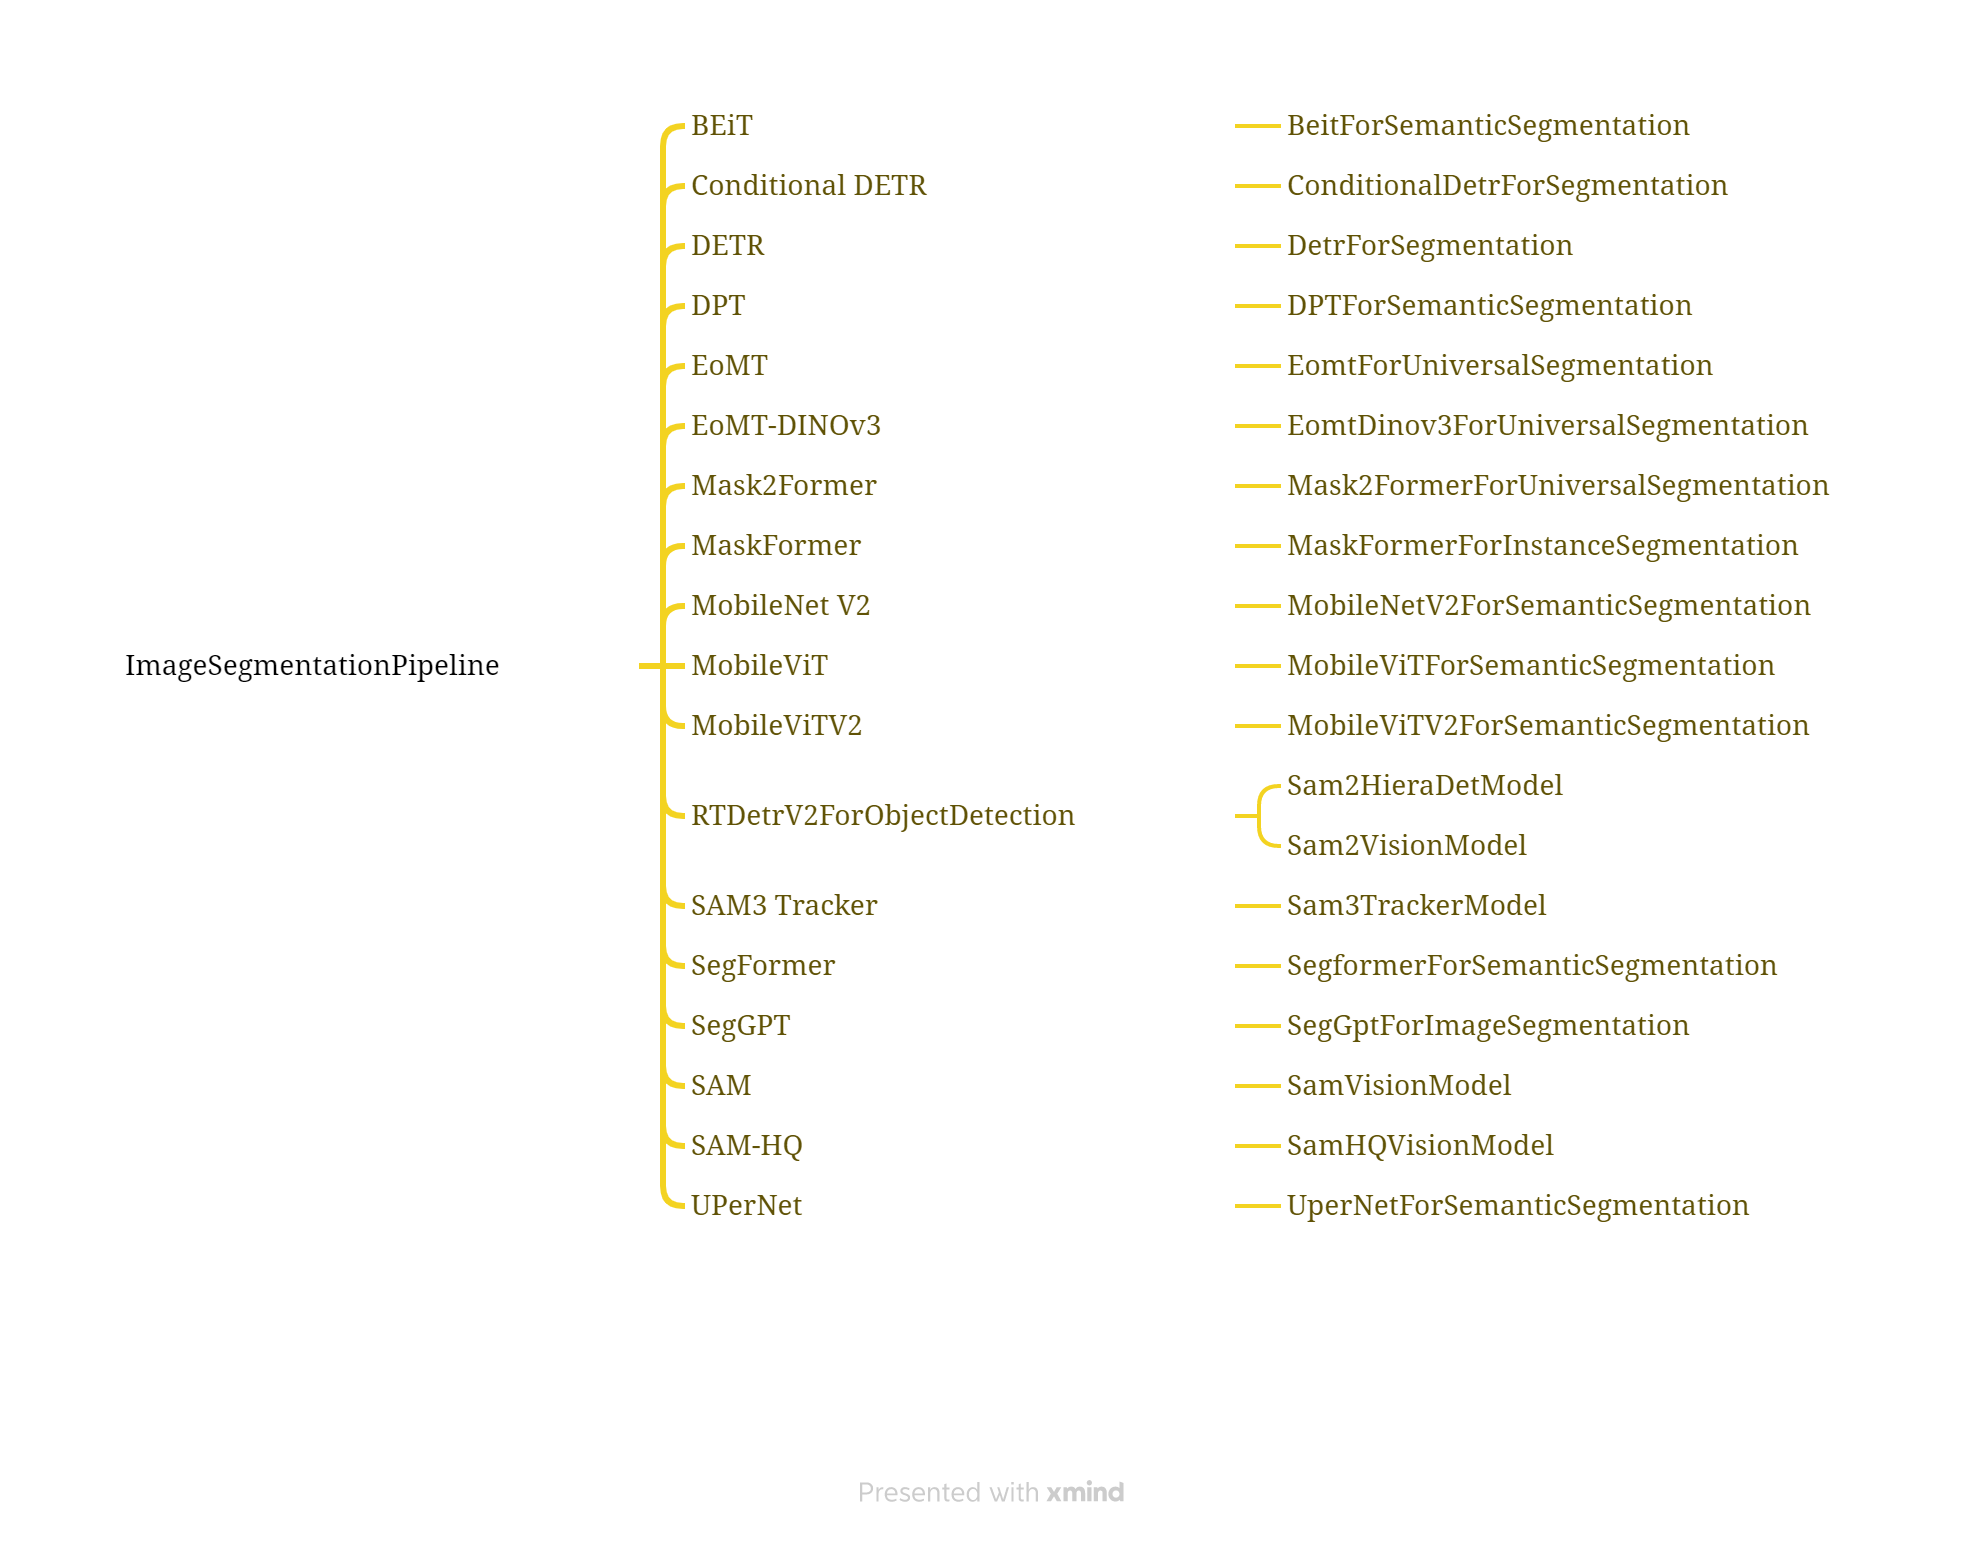

- 下面是我们需要介绍的分类分割模型：
    - 语义分割：
        - SegFormer
        - DPT (虽主要用于深度估计，但其架构也被用于语义分割)
    - 实例分割：
        - RF-DETR (支持实例分割)
        - MaskFormer (通过特定后处理可以实现）
    - 全景分割：
        - DETR (及其变体）
    - 通用模型：
        - Mask2Former
        - OneFormer

## 5.2. 语义分割模型应用

### (1) 模型下载

### (2) 模型应用

### (3) 模型分析

## 5.3. 实例分隔模型应用

### (1) 模型下载

### (2) 模型应用

### (3) 模型分析

## 5.4. 全景分隔模型应用

### (1) 模型下载

### (2) 模型应用

### (3) 模型分析

## 5.5. 通用分隔模型应用

### (1) 模型下载

### (2) 模型应用

### (3) 模型分析